#Import Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import re
import string

In [2]:
pip install imbalanced-learn

#Memuat Dataset

In [3]:
df = pd.read_csv('/content/ULASAN_TOKOPEDIA.csv')

print("Jumlah baris dan kolom:")
print(df.shape)

print("\nInformasi kolom:")
print(df.info())

print("\n5 baris pertama dataset:")
print(df.head())

Jumlah baris dan kolom:
(30000, 11)

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  19975 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          7562 non-null   object
 9   repliedAt             7562 non-null   object
 10  appVersion            19975 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB
None

5 baris pertama dataset:
                               reviewId         userName  \
0  30bc2f12-72d1-46bd-9fd3-d7ae372fe687  Pengg

In [4]:
print("\nJumlah nilai yang hilang per kolom:")
print(df.isnull().sum())


Jumlah nilai yang hilang per kolom:
reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    10025
at                          0
replyContent            22438
repliedAt               22438
appVersion              10025
dtype: int64


In [5]:
print("\nDistribusi rating:")
print(df['score'].value_counts())


Distribusi rating:
score
5    30000
Name: count, dtype: int64


#Data Preprocessing

####Cek Data Missing

In [6]:
df_cleaned = df.dropna(subset=['userName'])
print(df_cleaned.isnull().sum())

reviewId                    0
userName                    0
userImage                   0
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    10025
at                          0
replyContent            22438
repliedAt               22438
appVersion              10025
dtype: int64


####Text Cleaning

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_comment'] = df['content'].apply(clean_text)

####Labeling Sentimen

In [8]:
def get_sentiment(text):
    from textblob import TextBlob
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['cleaned_comment'].apply(get_sentiment)

#Data Preparation

In [9]:
y = LabelEncoder().fit_transform(df['label'])
X = df['cleaned_comment']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Eksperimen dengan 3 Skema Pelatihan

####Skema 1: SVM dengan TF-IDF(80/20 split)

In [10]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

smote = SMOTE(random_state=42)
X_train_tfidf_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print("Distribusi label setelah SMOTE:", Counter(y_train_smote))

Distribusi label setelah SMOTE: Counter({np.int64(1): 21340, np.int64(2): 21340, np.int64(0): 21340})


In [11]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf_smote, y_train_smote)
y_pred_svm = svm.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("\nEvaluasi Model SVM:")
print(f"Accuracy: {accuracy_svm}")
print(classification_report(y_test, y_pred_svm, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model SVM:
Accuracy: 0.9888333333333333
              precision    recall  f1-score   support

     negatif       0.95      0.68      0.79        59
      netral       0.99      1.00      0.99      5335
     positif       0.97      0.94      0.96       606

    accuracy                           0.99      6000
   macro avg       0.97      0.87      0.91      6000
weighted avg       0.99      0.99      0.99      6000



####Skema 2: Random Forest dengan Word2Vec (80/20 split)

In [12]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf_smote, y_train_smote)
y_pred_rf = rf.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nEvaluasi Model Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf, target_names=['negatif', 'netral', 'positif']))


Evaluasi Model Random Forest:
Accuracy: 0.9243333333333333
              precision    recall  f1-score   support

     negatif       1.00      0.03      0.07        59
      netral       0.92      1.00      0.96      5335
     positif       0.91      0.38      0.54       606

    accuracy                           0.92      6000
   macro avg       0.94      0.47      0.52      6000
weighted avg       0.92      0.92      0.91      6000



####Skema 3: Deep Learning LSTM (70/30 split)

In [13]:
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

y_train_cat = pd.get_dummies(y_train).values
y_test_cat = pd.get_dummies(y_test).values

In [14]:
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(128, return_sequences=True, kernel_regularizer='l2'),
    Dropout(0.5),
    LSTM(64, kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

history = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=15,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=callbacks
)

loss, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test_cat)
print("\nEvaluasi Model LSTM:")
print(f"Accuracy: {accuracy_lstm}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 157s 402ms/step - accuracy: 0.8775 - loss: 1.4160 - val_accuracy: 0.8892 - val_loss: 0.3855 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 192s 378ms/step - accuracy: 0.8889 - loss: 0.3951 - val_accuracy: 0.8892 - val_loss: 0.3828 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 152s 405ms/step - accuracy: 0.8884 - loss: 0.3913 - val_accuracy: 0.8892 - val_loss: 0.3819 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 234s 490ms/step - accuracy: 0.8889 - loss: 0.3869 - val_accuracy: 0.8892 - val_loss: 0.3829 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 172s 411ms/step - accuracy: 0.8883 - loss: 0.3889 - val_accuracy: 0.8892 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 206s 422ms/step - accuracy: 0.8887 - loss: 0.3907 - val_accuracy: 0.8892 - val_loss: 0.3822 - learning_rate: 0.0010
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 204s 427ms/step - accura

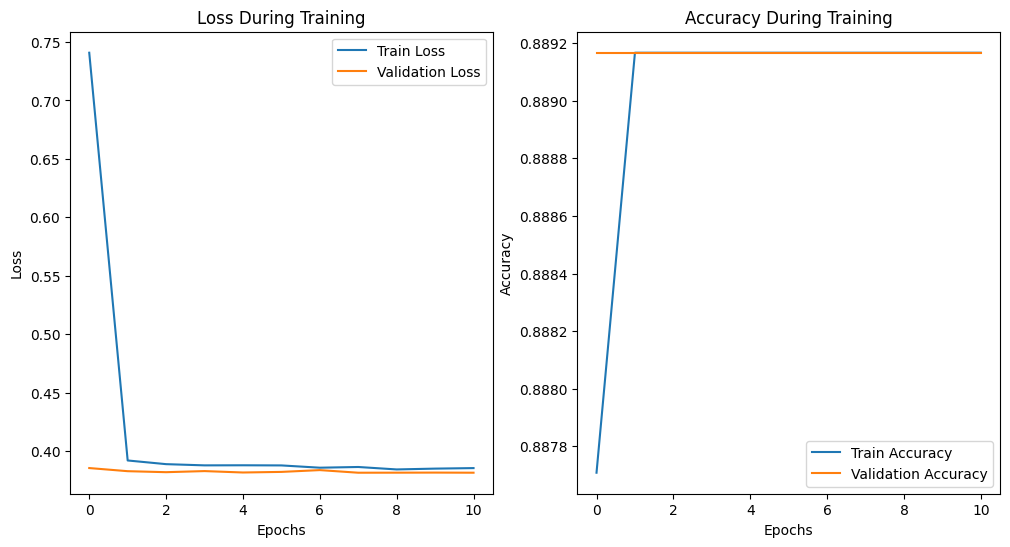

In [15]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#Testing

In [16]:
accuracies = {'SVM': accuracy_svm, 'Random Forest': accuracy_rf, 'LSTM': accuracy_lstm}

best_model_name = max(accuracies, key=accuracies.get)
print("\nModel terbaik berdasarkan akurasi:", best_model_name)


Model terbaik berdasarkan akurasi: SVM


In [17]:
le = LabelEncoder()
le.fit(df['label'])
if best_model_name == 'SVM':
    best_model = svm
    best_predictions = y_pred_svm
elif best_model_name == 'Random Forest':
    best_model = rf
    best_predictions = y_pred_rf
else:
    best_model = model_lstm
    best_predictions = model_lstm.predict(X_test_pad).argmax(axis=1)

comparison_df = pd.DataFrame({
    'Actual': le.inverse_transform(y_test),
    'Predicted': le.inverse_transform(best_predictions)
})
print("\nPerbandingan Label Asli dan Prediksi dengan Model Terbaik:")
print(comparison_df.head())


Perbandingan Label Asli dan Prediksi dengan Model Terbaik:
    Actual Predicted
0   netral    netral
1   netral    netral
2   netral    netral
3  positif   positif
4   netral    netral


In [18]:
!pip freeze > requirements.txt

df = pd.read_csv('requirements.txt', names=['Package'])
df.to_csv('requirements.csv', index=False)
